# Sommaire

- **Missions**
Vous êtes Data Engineer au Crédit Corporatif, une banque coopérative qui propose différents produits d’épargne responsable.

Le service marketing a passé une commande de création de base de données permettant de suivre la performance des campagnes marketing.

Le service marketing de la banque lance des campagnes marketing. Une campagne consiste à faire de la publicité pour les produits d’épargne de la banque. Ces publicités (appelées bannières publicitaires) s’affichent sur différents sites du web (chaque affichage sur un site quelconque est appelé une impression). Les internautes peuvent cliquer sur ces publicités, ils sont alors redirigés vers le site de la banque.


- **Données**

Les données sont disponibles [ici](https://github.com/MouslyDiaw/creez-dashboard/tree/main/data)

Les tables à créer sont:

    - impressions

    Chaque ligne correspond à une impression, c’est-à-dire à un affichage d’une publicité sur un site donné, et sur l’écran d’un utilisateur donné.

    Il contient 4 colonnes :
    timestamp : c’est une date codée, qui est la date d’affichage de la publicité.
    cookie_id permet d’identifier l’utilisateur qui a vu la publicité, chaque publicité étant liée à une campagne précise.
    campaign_id est l’identifiant de la campagne de marketing.
    external_site_id indique le site sur lequel la publicité s’est affichée

    Cette table contient 29 758 lignes

    - clics

    À la suite de l’affichage de ces publicités, certains utilisateurs cliquent dessus. La table clics enregistre la date et l’heure du clic dans timestamp, et l’utilisateur est repéré grâce à cookie_id.


    - achats

    Enfin, la table achats indique chaque achat réalisé par un utilisateur ayant cliqué sur une publicité. On y retrouve le timestamp, l’identifiant utilisateur cookie_id, le produit acheté product_id, son genre gender, son département de résidence dept, le prix d’achat price et son âge (age).
    
    
    
    
**Demandes d'analyse**: répondre aux questions suivantes:
- Quel est le chiffre d'affaires généré par Campagne ?
- Quel est le nombre d’affichages des bannières ?
- Combien de personnes viennent sur le site web (nombre de clics) ?
- Combien de personnes souscrivent aux offres ?
- autres analyses permettant de comprendre les performances clés d'une campagne


**PJ**: envoyer au plus tard le vendredi 16/06/2023 à 18h avec l'objet `TP - sqlalchemy`

# Packages

In [1]:
%reload_ext autoreload
%autoreload 2

from os import path
from pathlib import Path

import pandas as pd
import pendulum
import plotly.express as px
import seaborn as sns
from sqlalchemy import (create_engine,
                        Column,
                        Integer,
                        String,
                        Date,
                        text,
                        DateTime,
                        TIMESTAMP,
                        ForeignKey,
                       )
from sqlalchemy.inspection import inspect
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
from sqlalchemy_utils import database_exists, create_database
from ydata_profiling import ProfileReport

from utils import dateparser, recreate_database

# Settings & connector

In [2]:
# execution date
DATE_RUN = pendulum.now()

# data from github
INPUT_DATA_URI = "https://github.com/MouslyDiaw/creez-dashboard/blob/main/data"

# home directory
HOME_DIR = Path.cwd()
DATA_DIR = Path(HOME_DIR, "data")
DATA_DIR.mkdir(parents=True, exist_ok=True)  # create data directory if not exist

print(f"Home directory: {HOME_DIR} \nData directory: {DATA_DIR}")

Home directory: /Users/mouslydiaw/Downloads/data_engineer 
Data directory: /Users/mouslydiaw/Downloads/data_engineer/data


In [3]:
# create engine
engine = create_engine('sqlite:///:memory:', echo=True)

In [4]:
db_insp = inspect(engine)

In [5]:
db_insp.get_schema_names()

2023-06-17 10:55:29,086 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:29,088 INFO sqlalchemy.engine.Engine PRAGMA database_list
2023-06-17 10:55:29,089 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:29,091 INFO sqlalchemy.engine.Engine ROLLBACK


['main']

# Data collection

## Impressions

In [6]:
df_impressions = pd.read_csv(path.join(INPUT_DATA_URI, "impressions.csv?raw=true"),
                             sep=",", on_bad_lines='skip',
                             parse_dates=["timestamp"],
                             date_parser=dateparser,)
df_impressions.shape

(29758, 4)

In [7]:
df_impressions.head()

,timestamp,cookie_id,campaign_id,external_site_id
0,2025-11-01 01:00:04+00:00,2392769782,3,370668
1,2025-11-01 01:01:16+00:00,2693949047,1,339897
2,2025-11-01 01:02:00+00:00,6841408721,2,989339
3,2025-11-01 01:03:06+00:00,1457891936,1,530191
4,2025-11-01 01:03:55+00:00,5354259272,1,206900


In [8]:
df_impressions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29758 entries, 0 to 29757
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype                          
---  ------            --------------  -----                          
 0   timestamp         29758 non-null  datetime64[ns, Timezone('UTC')]
 1   cookie_id         29758 non-null  int64                          
 2   campaign_id       29758 non-null  int64                          
 3   external_site_id  29758 non-null  int64                          
dtypes: datetime64[ns, Timezone('UTC')](1), int64(3)
memory usage: 930.1 KB


In [9]:
df_impressions.describe(include="all", datetime_is_numeric=True)

,timestamp,cookie_id,campaign_id,external_site_id
count,29758,2.975800e+04,29758.000000,29758.000000
mean,2025-11-16 06:05:00.167080960+00:00,5.026531e+09,1.994119,501509.408058
min,2025-11-01 01:00:04+00:00,3.544420e+05,1.000000,45.000000
25%,2025-11-08 17:53:40.249999872+00:00,2.520960e+09,1.000000,249755.000000
50%,2025-11-16 05:27:50.500000+00:00,5.042014e+09,2.000000,502512.000000
75%,2025-11-23 19:53:09+00:00,7.548261e+09,3.000000,753595.750000
max,2025-12-01 11:49:02+00:00,9.999882e+09,3.000000,999903.000000
std,NaN,2.905848e+09,0.817771,289922.270987


## Clics

In [10]:
df_clics = pd.read_csv(path.join(INPUT_DATA_URI, "clics.csv?raw=true"),
                             sep=",", on_bad_lines='skip',
                             parse_dates=["timestamp"],
                             date_parser=dateparser,
                      )
df_clics.shape

(1775, 2)

In [11]:
df_clics.head()

,timestamp,cookie_id
0,2025-11-01 01:57:47+00:00,4217174943
1,2025-11-01 02:11:21+00:00,8581188253
2,2025-11-01 02:13:16+00:00,2693232025
3,2025-11-01 03:28:12+00:00,8905731989
4,2025-11-01 03:51:23+00:00,2071156755


## Achats

In [12]:
df_achats = pd.read_csv(path.join(INPUT_DATA_URI, "achats.csv?raw=true"),
                             sep=",", on_bad_lines='skip',
                             parse_dates=["timestamp"],
                             date_parser=dateparser,
                       )
df_achats.shape

(140, 7)

In [13]:
df_achats.head()

,timestamp,cookie_id,product_id,gender,dept,price,age
0,2025-11-16 14:33:26+00:00,7048447933,1,m,88,354,65
1,2025-11-17 00:58:46+00:00,9138057668,8,f,55,165,37
2,2025-11-17 17:00:55+00:00,1327443078,3,f,15,29,28
3,2025-11-18 08:45:17+00:00,1083555113,3,f,7,29,23
4,2025-11-19 09:10:15+00:00,665955021,6,f,95,34,25


# Database creation

## Create tables

In [14]:
Session = sessionmaker(bind=engine)
session = Session()
Base = declarative_base()

In [15]:
class Impressions(Base):
    """Create impressions table in DB."""
    __tablename__ = "impressions"
    __table_args__ = {'extend_existing': True} 
    
    impression_id = Column(Integer, primary_key=True, autoincrement=True)
    cookie_id = Column(String)
    timestamp = Column(TIMESTAMP)
    campaign_id = Column(String)
    external_site_id = Column(String)
    # clics = relationship("Clics", backref='impression')


class Clics(Base):
    """Create clcis table in DB."""
    __tablename__ = "clics"
    __table_args__ = {'extend_existing': True} 
    
    clic_id = Column(Integer, primary_key=True, autoincrement=True)
    cookie_id = Column(String, ForeignKey(f"{Impressions.__tablename__}.cookie_id", ondelete="CASCADE"))
    timestamp = Column(TIMESTAMP)
    # achats = relationship("Achats", backref='achat')


class Achats(Base):
    """Create impression achats in DB."""
    __tablename__ = 'achats'
    __table_args__ = {'extend_existing': True} 

    achat_id = Column(Integer, primary_key=True, autoincrement=True)
    cookie_id = Column(String, ForeignKey(f"{Clics.__tablename__}.cookie_id", ondelete="CASCADE"))
    timestamp = Column(TIMESTAMP)
    product_id = Column(Integer)
    gender = Column(String)
    dept = Column(String)
    price = Column(Integer)
    age = Column(Integer)

In [16]:
Base.metadata.create_all(engine, checkfirst=True)

2023-06-17 10:55:33,781 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:33,782 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("impressions")
2023-06-17 10:55:33,784 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:33,786 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("impressions")
2023-06-17 10:55:33,788 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:33,791 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("clics")
2023-06-17 10:55:33,795 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:33,802 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("clics")
2023-06-17 10:55:33,808 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:33,811 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("achats")
2023-06-17 10:55:33,814 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:33,818 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("achats")
2023-06-17 10:55:33,822 INFO sqlalchemy.engine.Engine [raw sql] 

In [17]:
db_insp = inspect(engine)

In [18]:
db_insp.get_table_names()

2023-06-17 10:55:34,222 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:34,231 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:55:34,247 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:34,251 INFO sqlalchemy.engine.Engine ROLLBACK


['achats', 'clics', 'impressions']

In [19]:
db_insp.get_columns(table_name="impressions")

2023-06-17 10:55:34,472 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:34,512 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("impressions")
2023-06-17 10:55:34,528 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:34,553 INFO sqlalchemy.engine.Engine ROLLBACK


[{'name': 'impression_id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'cookie_id',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'timestamp',
  'type': TIMESTAMP(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'campaign_id',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'external_site_id',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [20]:
db_insp.get_columns(table_name="clics")

2023-06-17 10:55:34,897 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:34,905 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("clics")
2023-06-17 10:55:34,911 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:34,917 INFO sqlalchemy.engine.Engine ROLLBACK


[{'name': 'clic_id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'cookie_id',
  'type': VARCHAR(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'timestamp',
  'type': TIMESTAMP(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [21]:
achats_schema = db_insp.get_columns(table_name="achats")

for fields in achats_schema:
    print(fields["name"])

2023-06-17 10:55:35,217 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:35,220 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("achats")
2023-06-17 10:55:35,222 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:35,230 INFO sqlalchemy.engine.Engine ROLLBACK
achat_id
cookie_id
timestamp
product_id
gender
dept
price
age


In [22]:
# drop and recreate all tables
recreate_database(meta_base=Base, engine=engine)

2023-06-17 10:55:35,400 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:35,405 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("impressions")
2023-06-17 10:55:35,407 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:35,411 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("clics")
2023-06-17 10:55:35,417 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:35,423 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("achats")
2023-06-17 10:55:35,428 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:35,475 INFO sqlalchemy.engine.Engine 
DROP TABLE achats
2023-06-17 10:55:35,481 INFO sqlalchemy.engine.Engine [no key 0.00555s] ()
2023-06-17 10:55:35,484 INFO sqlalchemy.engine.Engine 
DROP TABLE clics
2023-06-17 10:55:35,488 INFO sqlalchemy.engine.Engine [no key 0.00324s] ()
2023-06-17 10:55:35,499 INFO sqlalchemy.engine.Engine 
DROP TABLE impressions
2023-06-17 10:55:35,518 INFO sqlalchemy.engine.Engine [no key 0.01855s] ()
2023-06-17 10:5

## Insert data

In [23]:
def insert_data(data, table_name, engine, if_exists="append"):
    data.to_sql(name=table_name,
                con=engine.connect(),
                if_exists=if_exists,
                index=False
               )

In [24]:
# insert impressions data
insert_data(data=df_impressions,
            table_name=Impressions.__tablename__,
            engine=engine,
            if_exists="replace",
)

2023-06-17 10:55:35,986 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:35,989 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("impressions")
2023-06-17 10:55:35,991 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:35,995 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("impressions")
2023-06-17 10:55:35,998 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:36,010 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:55:36,014 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:36,016 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:55:36,018 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:36,020 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("impressions")
2023-06-17 10:55:36,024 INFO sqlalchemy.engine.Engine [raw sq

In [25]:
# insert clics data
insert_data(data=df_clics,
            table_name=Clics.__tablename__,
            engine=engine,
            if_exists="replace",
)

2023-06-17 10:55:37,118 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:55:37,119 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("clics")
2023-06-17 10:55:37,120 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:37,122 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("clics")
2023-06-17 10:55:37,124 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:37,127 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:55:37,130 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:37,132 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:55:37,148 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:55:37,152 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("clics")
2023-06-17 10:55:37,157 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 1

In [29]:
# insert achats data
insert_data(data=df_achats,
            table_name=Achats.__tablename__,
            engine=engine,
            if_exists="replace",
)

2023-06-17 10:59:17,235 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:59:17,237 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("achats")
2023-06-17 10:59:17,240 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:59:17,244 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("achats")
2023-06-17 10:59:17,245 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:59:17,249 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:59:17,251 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:59:17,255 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_temp_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2023-06-17 10:59:17,257 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-17 10:59:17,260 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("achats")
2023-06-17 10:59:17,261 INFO sqlalchemy.engine.Engine [raw sql] ()
2023-06-1

# Analysis

## Check saved data

In [30]:
pd.read_sql(text("SELECT COUNT(*) FROM impressions"), con=engine.connect())

2023-06-17 10:59:17,831 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:59:17,834 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM impressions
2023-06-17 10:59:17,839 INFO sqlalchemy.engine.Engine [generated in 0.00851s] ()


,COUNT(*)
0,29758


In [31]:
pd.read_sql(text("SELECT COUNT(*) FROM clics"), con=engine.connect())

2023-06-17 10:59:17,992 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:59:18,006 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM clics
2023-06-17 10:59:18,009 INFO sqlalchemy.engine.Engine [generated in 0.01634s] ()


,COUNT(*)
0,1775


In [32]:
pd.read_sql(text("SELECT COUNT(*) FROM achats"), con=engine.connect())

2023-06-17 10:59:18,210 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 10:59:18,221 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM achats
2023-06-17 10:59:18,226 INFO sqlalchemy.engine.Engine [generated in 0.01595s] ()


,COUNT(*)
0,140


In [33]:
df_achats.head()

,timestamp,cookie_id,product_id,gender,dept,price,age
0,2025-11-16 14:33:26+00:00,7048447933,1,m,88,354,65
1,2025-11-17 00:58:46+00:00,9138057668,8,f,55,165,37
2,2025-11-17 17:00:55+00:00,1327443078,3,f,15,29,28
3,2025-11-18 08:45:17+00:00,1083555113,3,f,7,29,23
4,2025-11-19 09:10:15+00:00,665955021,6,f,95,34,25


## Extract data from DB

In [80]:
data = pd.read_sql(text("""
                        SELECT imp.*,
                                CASE WHEN
                                 cl.cookie_id IS NOT NULL THEN 1
                                 ELSE 0
                                END AS is_clic,
                                cl.timestamp as clic_timestamp,
                                ac.cookie_id IS NOT NULL AS is_achat,
                                ac.product_id,
                                ac.gender,
                                ac.dept,
                                ac.price,
                                ac.age,
                                ac.timestamp AS achat_timestamp
                          FROM impressions AS imp
                     LEFT JOIN clics AS cl
                            ON cl.cookie_id = imp.cookie_id
                     LEFT JOIN achats ac
                            ON ac.cookie_id = cl.cookie_id
                        """,
                       ),
                   con=engine.connect(),
                   parse_dates=["timestamp", "clic_timestamp", "achat_timestamp"],
                  )

# change column types
data = data.astype({"external_site_id": str,
                    "cookie_id": str,
                    "product_id": str,
                    "campaign_id": str,
                   }
           )
data.shape

2023-06-17 11:51:44,832 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2023-06-17 11:51:44,834 INFO sqlalchemy.engine.Engine 
                        SELECT imp.*,
                                CASE WHEN
                                 cl.cookie_id IS NOT NULL THEN 1
                                 ELSE 0
                                END AS is_clic,
                                cl.timestamp as clic_timestamp,
                                ac.cookie_id IS NOT NULL AS is_achat,
                                ac.product_id,
                                ac.gender,
                                ac.dept,
                                ac.price,
                                ac.age,
                                ac.timestamp AS achat_timestamp
                          FROM impressions AS imp
                     LEFT JOIN clics AS cl
                            ON cl.cookie_id = imp.cookie_id
                     LEFT JOIN achats ac
                            ON ac.co

(29758, 13)

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29758 entries, 0 to 29757
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         29758 non-null  datetime64[ns]
 1   cookie_id         29758 non-null  object        
 2   campaign_id       29758 non-null  object        
 3   external_site_id  29758 non-null  object        
 4   is_clic           29758 non-null  int64         
 5   clic_timestamp    1775 non-null   datetime64[ns]
 6   is_achat          29758 non-null  int64         
 7   product_id        29758 non-null  object        
 8   gender            140 non-null    object        
 9   dept              140 non-null    object        
 10  price             140 non-null    float64       
 11  age               140 non-null    float64       
 12  achat_timestamp   140 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(2), object(6)
memory usage: 3.0+ MB


In [82]:
data.head()

,timestamp,cookie_id,campaign_id,external_site_id,is_clic,clic_timestamp,is_achat,product_id,gender,dept,price,age,achat_timestamp
0,2025-11-01 01:00:04,2392769782,3,370668,0,NaT,0,nan,None,None,NaN,NaN,NaT
1,2025-11-01 01:01:16,2693949047,1,339897,0,NaT,0,nan,None,None,NaN,NaN,NaT
2,2025-11-01 01:02:00,6841408721,2,989339,0,NaT,0,nan,None,None,NaN,NaN,NaT
3,2025-11-01 01:03:06,1457891936,1,530191,0,NaT,0,nan,None,None,NaN,NaN,NaT
4,2025-11-01 01:03:55,5354259272,1,206900,0,NaT,0,nan,None,None,NaN,NaN,NaT


In [37]:
# check clic / achat coherency
data.pivot_table(index="is_clic", columns="is_achat",
                 values="cookie_id", aggfunc="count",
                 margins=True, 
            )

is_achat,0,1,All
is_clic,,,
0,27983.0,NaN,27983
1,1635.0,140.0,1775
All,29618.0,140.0,29758


## EDA

In [38]:
campaign_report = ProfileReport(data, title="Markeitng Campaign Report",
                                interactions=None,
                                correlations=None,
                               )
campaign_report.to_notebook_iframe()  # Used to output the HTML representation to a Jupyter notebook.

# campaign_report.to_file(f"{DATE_RUN.to_date_string()}-campaign_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## CA per campaign

In [39]:
ca_per_campaign = data.groupby("campaign_id", as_index=False).agg(ca=("price", "sum"))
ca_per_campaign.head()

,campaign_id,ca
0,1,5223.0
1,2,8117.0
2,3,7073.0


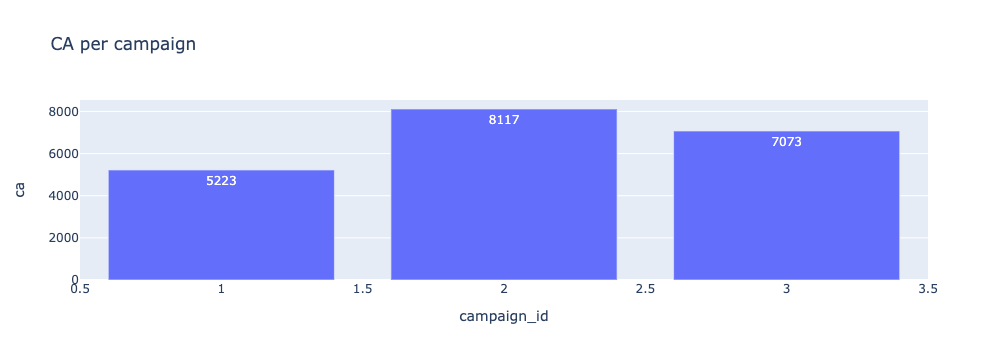

In [96]:
px.bar(data_frame=ca_per_campaign, x="campaign_id", y="ca",
       text_auto=True,
       title="CA per campaign"
      )

## Number of clics

In [41]:
data.head()

,timestamp,cookie_id,campaign_id,external_site_id,is_clic,clic_timestamp,is_achat,product_id,gender,dept,price,age,achat_timestamp
0,2025-11-01 01:00:04,2392769782,3,370668,0,NaT,0,NaN,None,None,NaN,NaN,NaT
1,2025-11-01 01:01:16,2693949047,1,339897,0,NaT,0,NaN,None,None,NaN,NaN,NaT
2,2025-11-01 01:02:00,6841408721,2,989339,0,NaT,0,NaN,None,None,NaN,NaN,NaT
3,2025-11-01 01:03:06,1457891936,1,530191,0,NaT,0,NaN,None,None,NaN,NaN,NaT
4,2025-11-01 01:03:55,5354259272,1,206900,0,NaT,0,NaN,None,None,NaN,NaN,NaT


In [42]:
nb_clics_per_hour = (data
                     .groupby(["campaign_id", pd.Grouper(key="clic_timestamp", freq="D")])
                     .agg(nb_clics= ("is_clic", "sum"))
                     .reset_index(drop=False)
                    )
nb_clics_per_hour.shape

(93, 3)

In [43]:
nb_clics_per_hour.head()

,campaign_id,clic_timestamp,nb_clics
0,1,2025-11-01,16
1,1,2025-11-02,15
2,1,2025-11-03,16
3,1,2025-11-04,16
4,1,2025-11-05,18


In [44]:
nb_clics_per_hour.campaign_id.value_counts()

1    31
2    31
3    31
Name: campaign_id, dtype: int64

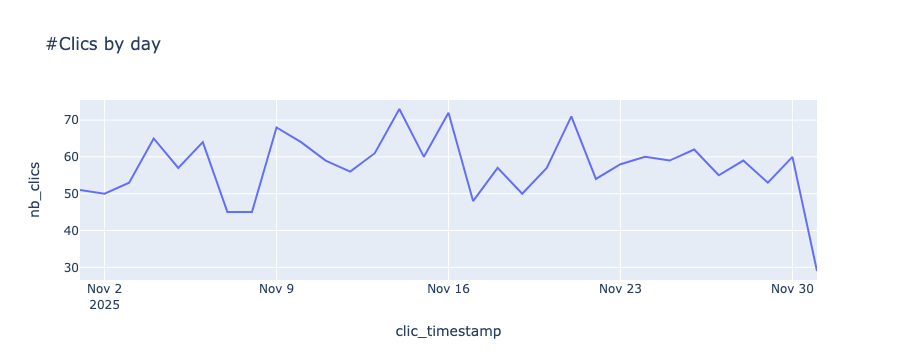

In [45]:
fig = px.line(data_frame=(nb_clics_per_hour
                          .groupby("clic_timestamp")
                          .nb_clics.sum()
                          .reset_index()
                         ),
              x='clic_timestamp', y="nb_clics",
             title="#Clics by day")
fig.show()

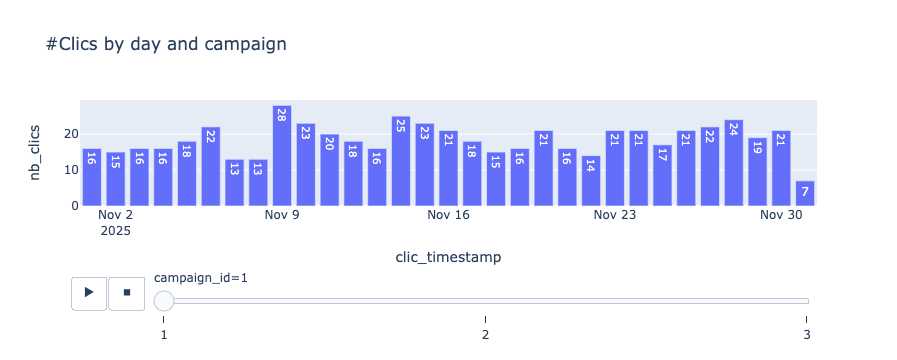

In [46]:
# clic per date & campaign
fig = px.bar(nb_clics_per_hour,
             x="clic_timestamp", y="nb_clics", animation_frame="campaign_id",
             text_auto=True, title="#Clics by day and campaign"
            )
fig.show()

## Subscription

In [47]:
nb_impressions = len(data)
nb_clics, nb_achats = data[["is_clic", "is_achat"]].sum()
df_conversion = pd.DataFrame({"name_kpi": ["impressions", "clics", "achats"],
                              "value_kpi": [nb_impressions, nb_clics, nb_achats]})
df_conversion

,name_kpi,value_kpi
0,impressions,29758
1,clics,1775
2,achats,140


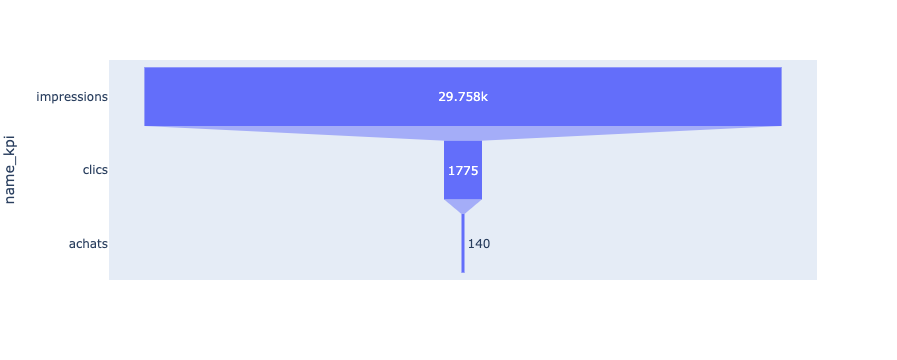

In [48]:
fig = px.funnel(df_conversion, x='value_kpi', y='name_kpi')
fig.show()

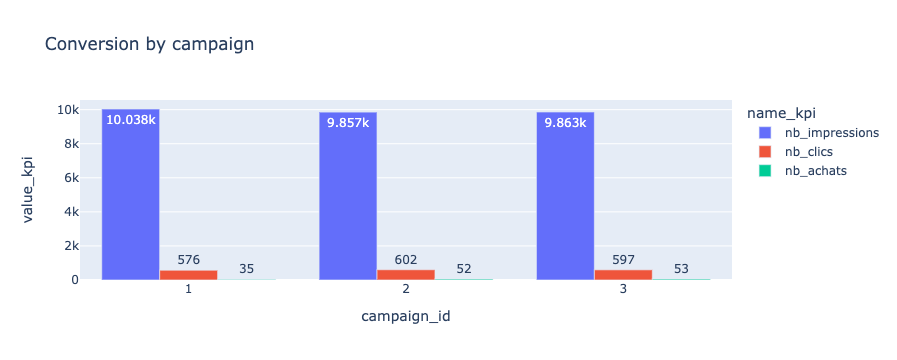

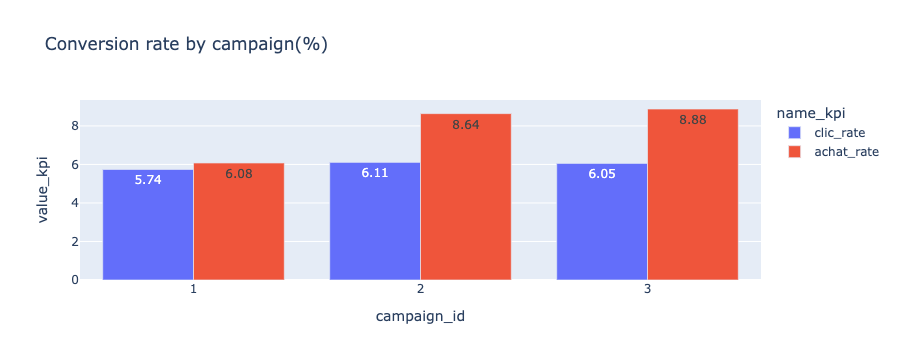

In [49]:
col_dimension = "campaign_id"
conversion_per_campaign = (data
                           .groupby(col_dimension, as_index=False)
                           .agg(nb_impressions=("cookie_id", "count"),
                                nb_clics=("is_clic", "sum"),
                                nb_achats=("is_achat", "sum"),
                               )
                           .assign(clic_rate=lambda dfr: 100 * dfr.nb_clics / dfr.nb_impressions,
                                   achat_rate=lambda dfr: 100 * dfr.nb_achats / dfr.nb_clics,
                                  )
                           )
            
# value_vars = ["clic_rate", "achat_rate"]  # ["nb_impressions", "nb_clics", "nb_achats"]

for (value_vars, text_fmt, title) in [(("nb_impressions", "nb_clics", "nb_achats"),
                                       True, "Conversion by campaign"),
                                      (("clic_rate", "achat_rate"),
                                       ".2f", "Conversion rate by campaign(%)")
                                     ]:
    fig = px.bar(data_frame=(conversion_per_campaign
                             .melt(id_vars=col_dimension, value_vars=value_vars,
                                   var_name="name_kpi", value_name="value_kpi")),
                 color="name_kpi", y="value_kpi", x=col_dimension,
                 barmode="group", text_auto=text_fmt,
                 title=title)
    fig.show()

## Age

In [50]:
data.groupby("product_id").age.describe()

,count,mean,std,min,25%,50%,75%,max
product_id,,,,,,,,
1.0,14.0,63.928571,2.894671,59.0,62.25,63.0,65.75,69.0
2.0,20.0,29.150000,3.297128,23.0,26.75,30.0,30.25,36.0
3.0,21.0,25.142857,3.453776,19.0,22.00,25.0,28.00,31.0
4.0,23.0,58.260870,3.346876,52.0,56.00,58.0,60.50,65.0
5.0,23.0,33.217391,7.850631,21.0,27.00,35.0,38.00,45.0
6.0,9.0,26.111111,2.666667,21.0,25.00,26.0,28.00,29.0
7.0,12.0,34.666667,10.165300,21.0,28.25,35.5,38.00,56.0
8.0,18.0,39.500000,13.129446,20.0,34.00,36.5,43.75,67.0


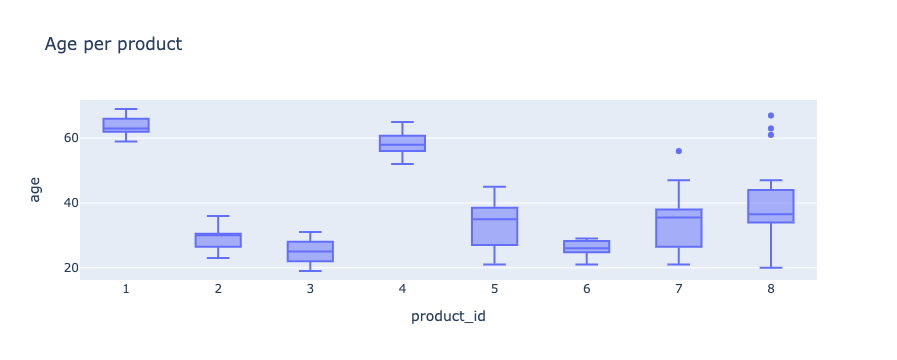

In [51]:
px.box(data, x="product_id", y="age", title="Age per product")

## Site performances

In [86]:
site_perfs = (data
              .groupby("external_site_id", as_index=False)
              .agg(nb_impressions=("cookie_id", "count"),
                   nb_clics=("is_clic", "sum"),
                   nb_achat=("is_achat", "sum"),
                  )
              .assign(click_rate=lambda dfr: dfr.nb_clics.div(dfr.nb_impressions))
             )
site_perfs

,external_site_id,nb_impressions,nb_clics,nb_achat,click_rate
0,10010,2,0,0,0.0
1,100152,2,0,0,0.0
2,100197,3,0,0,0.0
3,100242,2,1,1,0.5
4,100287,2,0,0,0.0
...,...,...,...,...,...
12875,999723,1,0,0,0.0
12876,999768,1,0,0,0.0
12877,999813,1,0,0,0.0
12878,999858,3,0,0,0.0


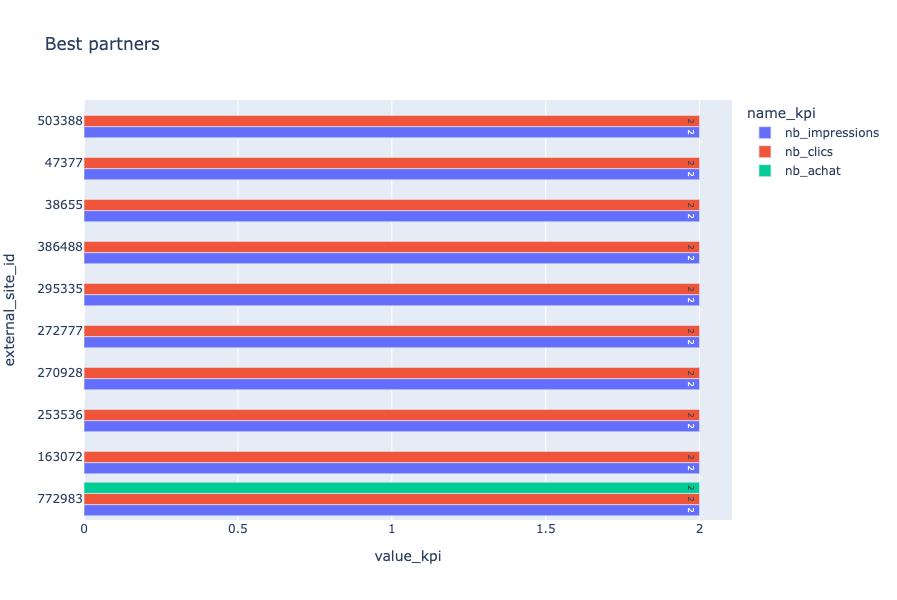

In [90]:
# select Topn
topn = 10
fig = px.bar(data_frame=(site_perfs.nlargest(n=topn, columns=["click_rate", "nb_clics", "nb_achat"])
                             .melt(id_vars="external_site_id",
                                   value_vars=["nb_impressions", "nb_clics", "nb_achat"],
                                   var_name="name_kpi", value_name="value_kpi")
                        ),
                 color="name_kpi", x="value_kpi", y="external_site_id",
                 orientation="h",
                 barmode="group", text_auto=True,
                 width=700,
                 height=600,
                 title="Best partners")
fig.show()

## Best products

In [94]:
best_products = (data
                 .groupby("product_id", as_index=False)
                 .agg(nb_impressions=("cookie_id", "count"),
                   nb_clics=("is_clic", "sum"),
                   nb_achat=("is_achat", "sum"),
                  )
                 .assign(click_rate=lambda dfr: dfr.nb_clics.div(dfr.nb_impressions))
                 .nlargest(10, columns=["click_rate", "nb_achat"])
             )
best_products

,product_id,nb_impressions,nb_clics,nb_achat,click_rate
3,4.0,23,23,23,1.000000
4,5.0,23,23,23,1.000000
2,3.0,21,21,21,1.000000
1,2.0,20,20,20,1.000000
7,8.0,18,18,18,1.000000
0,1.0,14,14,14,1.000000
6,7.0,12,12,12,1.000000
5,6.0,9,9,9,1.000000
8,nan,29618,1635,0,0.055203
